# PatternNet example on MNIST
This notebook trains a classification network on the MNIST data set and subsequently creates a PatternNet for this network and shows how to use PatternNet for signal computation.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import networks
import layers
from utils import load_data_mnist as load_data
from utils import accuracy, train


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Data and MNIST network 

In [2]:
# get the data
trainloader, testloader, _ = load_data(128)

# initialize the MNIST network
net = networks.MnistNet()

In [3]:
# print the layers for an overview of the network architecture
net.layers

[Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1)),
 ReLU(),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Linear(in_features=1024, out_features=120, bias=True),
 ReLU(),
 Linear(in_features=120, out_features=84, bias=True),
 ReLU(),
 Linear(in_features=84, out_features=10, bias=True)]

In [4]:
# set the number of epochs used for training
train_epochs = 2

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
# train the network
train(net, train_epochs, trainloader, criterion, optimizer)

# get the accuracy
accuracy(net, testloader)

Finished Training in 66 seconds
Accuracy: 0.988000


0.988

In [5]:
# get test images, always use the same for easier comparisons
data = np.load("test_images.npy")

# reshape for pytorch usage
data = torch.FloatTensor(data.transpose(0,3,1,2))

# Create Patternnet
To create your own PatternNet there are two possibilities to proceed. You can use the *PatternNet* class to create a PatternNet on a given network or you can stack single PatternLayers. 



## PatternNet class
The PatternNet is initialized with a list of a network's layers in the order that they are called during a forward pass. For easy initialization here, the MNIST network has an attribute *layers* that returns this list. 

In [6]:
# initialize patternnet with the MNIST networks' layers
patternnet = networks.PatternNet(net.layers)

After initialization the patterns that are used for the signal computations are just randomly initialized weights. To change this you have to execute three steps. 

First compute statistics of the inputs and outputs of the dense and convolutional layers. For this the *PatternNet* class provides the method *compute_statistics(data)*. The patternnet automatically computes the inputs and outputs of each dense or conovolutional layer in the forward pass and computes the statistics. The statistics are saved additionally to any patterns since the statistics can be updated with new data in a linear way. 

Second the patterns have to be computed from the already computed statistics. For this a simple call of the *compute_patterns()* method is sufficient. 

And third the patterns need to be set as weights for the signal computation. Two types of patterns are saved in for each layer after the *compute_patterns()* call, *linear* and *relu* patterns. By calling the patternnet method *set_patterns()* the *relu* patterns (which correspond to the two-component estimator of the PatternNet paper) are set. If you want to set the *linear* patterns, call the method with *pattern_type='linear'*.

In [7]:
# compute statistics 
patternnet.compute_statistics(data)
# compute patterns
patternnet.compute_patterns()
# set patterns
patternnet.set_patterns()

### Signal examples

In [8]:
# function to normalize images such that the maximum value is 1 and the minimum 0
def normalize_img(img):
    img_n = img - img.min()
    img_n = img_n / img_n.max()
    
    return img_n

When the patterns have been computed and set the signal of some input can be computed by calling the patternnet on the input data. Note that this would also work before having computed any patterns, but then the random weights from the initialization would be used. 

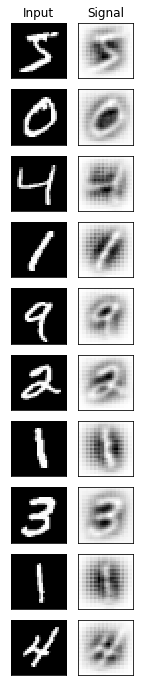

In [9]:
# compute signals
signals = patternnet(data[:10])

# plot signals
plt.figure(figsize=(7,12))
for i in range(10):
    plt.subplot(10,6,i*6+2)
    if i == 0:
        plt.title('Signal')
    plt.imshow(normalize_img(signals.data[i,0]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(10,6,i*6+1)
    if i == 0:
        plt.title('Input')
    plt.imshow(normalize_img(data[i,0]), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## PatternLayers
The *PatternNet* class can only be used on certain networks (only sequential network of Conv2d, Linear, MaxPooling2d, ReLU layers and only one change between convolutional and dense layers). For all other networks (or if you simply want to have more control) you can still create a PatternNet by using the PatternLayers and stacking them. An example for one of these layers and its usage is given here. For more information on the other PatternLayers have a look at the tutorial in this link: https://docs.google.com/document/d/1g3x_aqMbcYw56OPjb3qs6GzEjdsEHxsuRXILKpsfCYE/edit?usp=sharing

### PatternConv2d
The *PatternConv2d* layer can be initialized on a Conv2d layer and implements the following methods:
- forward(data): computes the output of the Conv2d layer on the input data *data*; If the Conv2d layer has a bias term the forward function also returns the output without the bias term because it is needed for the statistics computation
- compute_statistics(input, output_with_bias, output_without_bias): computes the statistics for the Conv2d layer; output_without_bias can also be omitted if the layer does not have a bias term
- compute_patterns(): computes the patterns on previously computed statistics
- set_patterns(): sets the weights for the backward pass to the computed patterns; Similar to the set_patterns() method of the *PatternNet* class the patterns can be set to *relu* or *linear* patterns (call with *pattern_type='relu'* or *pattern_type='linear'*, if called with none *'relu'* patterns are used)
- backward(output_data): computes the backward pass with the set patterns; 

In [10]:
# create example PatternConv2d layer
conv_pattern = layers.PatternConv2d(net.layers[0])
# print the layer 
print(conv_pattern)

# before we can compute the statistics we need the output of the layer 
# from a forward pass (with and without bias applied)
conv_output_w_bias, conv_output_wo_bias = conv_pattern.forward(data)
# now we can compute the statistics
conv_pattern.compute_statistics(data, conv_output_w_bias, conv_output_wo_bias)
# compute the patterns
conv_pattern.compute_patterns()
# and set the patterns
conv_pattern.set_patterns()

# now we can also compute a backward pass with the computed patterns
conv_signal = conv_pattern.backward(conv_output_w_bias)

PatternConv2d(
  (forward_layer): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (backward_layer): Conv2d(16, 1, kernel_size=[5 5], stride=(1, 1), padding=(4, 4), bias=False)
)
